# Hospital Readmission Prediction

by Muhammad Naufal Razan Napitupulu

### Data Cleaning and Preprocessing

In [ ]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv("dataset_diabetes/dataset_diabetes/diabetic_data.csv")

# Replace '?' with NaN
df_clean = df.replace('?', np.nan)

# Drop irrelevant identifiers
df_clean.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)

### Convert Target Column into Binary

In [ ]:
# Convert target to binary: readmitted <30 = 1, else 0
df_clean['readmitted_binary'] = df_clean['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

### Label Encoding

In [ ]:
# Convert age brackets to numeric
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df_clean['age'] = df_clean['age'].map(age_mapping)

In [ ]:
# Convert categorical to binary
df_clean['change'] = df_clean['change'].map({'Ch': 1, 'No': 0})
df_clean['diabetesMed'] = df_clean['diabetesMed'].map({'Yes': 1, 'No': 0})

### Drop Columns with Lots of Missing Values

In [ ]:
# Drop high-missing-value columns
df_clean.drop(columns=['weight', 'medical_specialty', 'payer_code', 'race', 'diag_3'], inplace=True)

# Drop rows with any remaining missing values
df_clean.dropna(inplace=True)


### Encode Categorical Columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encode all object-type categorical variables
categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()
le = LabelEncoder()
for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col])


### Train/Test Split

In [ ]:
# Split features and target
X = df_clean.drop(columns=['readmitted', 'readmitted_binary'])
y = df_clean['readmitted_binary']

# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


### SMOTE Balancing

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


### Test Base Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_resampled, y_resampled)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)


c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(random_state=42)

### Evaluate Base Models

In [9]:

from sklearn.metrics import classification_report, roc_auc_score

# Predict
logreg_preds = logreg.predict(X_test)
rf_preds = rf.predict(X_test)

# Evaluate
print("Logistic Regression")
print(classification_report(y_test, logreg_preds))
print("AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))

print("\nRandom Forest")
print(classification_report(y_test, rf_preds))
print("AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.77      0.83        53
           1       0.14      0.29      0.19         7

    accuracy                           0.72        60
   macro avg       0.52      0.53      0.51        60
weighted avg       0.80      0.72      0.75        60

AUC: 0.490566037735849

Random Forest
              precision    recall  f1-score   support

           0       0.91      0.96      0.94        53
           1       0.50      0.29      0.36         7

    accuracy                           0.88        60
   macro avg       0.71      0.62      0.65        60
weighted avg       0.86      0.88      0.87        60

AUC: 0.6361185983827492


**Both base models have very low AUC, none that will be helpful for an actual prediction.**

### Check Important Features for Future References

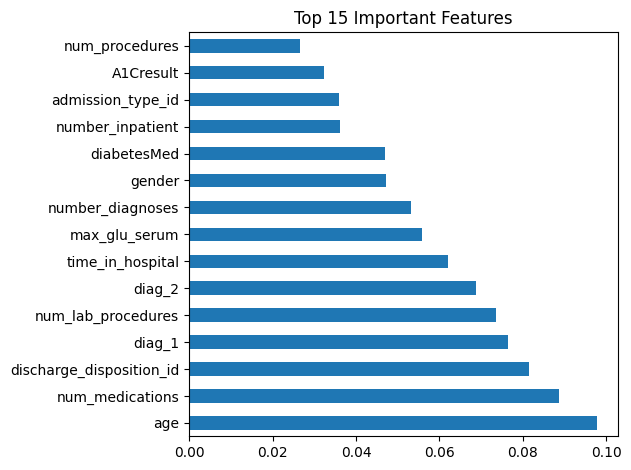

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature importance from Random Forest
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh', title='Top 15 Important Features')
plt.tight_layout()
plt.show()


**Here, we can see age matters most for the Random Forest model, with number of medications being the runner-up**

### Try Other Ready-To-Tune Models

In [18]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgbm = LGBMClassifier(eval_metric='logloss')
catb = CatBoostClassifier(verbose=0)

xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
catb.fit(X_train, y_train)

c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:17:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 29, number of negative: 208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 237, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122363 -> initscore=-1.970242
[LightGBM] [Info] Start training from score -1.970242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

### Evaluate Models

In [20]:
xgb_preds = xgb.predict(X_test)
lgbm_preds = lgbm.predict(X_test)
catb_preds = catb.predict(X_test)


print("XGBoost")
print(classification_report(y_test, xgb_preds))
print("AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

print("\nLightGBM")
print(classification_report(y_test, lgbm_preds))
print("AUC:", roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))

print("\nCatBoost")
print(classification_report(y_test, catb_preds))
print("AUC:", roc_auc_score(y_test, catb.predict_proba(X_test)[:, 1]))

[LightGBM] [Warning] Unknown parameter: eval_metric
XGBoost
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        53
           1       1.00      0.29      0.44         7

    accuracy                           0.92        60
   macro avg       0.96      0.64      0.70        60
weighted avg       0.92      0.92      0.90        60

AUC: 0.7493261455525606

LightGBM
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        53
           1       1.00      0.14      0.25         7

    accuracy                           0.90        60
   macro avg       0.95      0.57      0.60        60
weighted avg       0.91      0.90      0.87        60

[LightGBM] [Warning] Unknown parameter: eval_metric
AUC: 0.7196765498652291

CatBoost
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        53
           1       1.00      0.14      0.25         7

  

### Best Model was XGBoost, now we try to tune hyperparameter to try to get a better result.

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Set class weight based on imbalance
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight],
    'gamma': [0, 1, 3],
    'min_child_weight': [1, 5, 10]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    scoring='roc_auc',
    cv=3,
    n_iter=20,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_resampled, y_resampled)

print("Best AUC:", random_search.best_score_)
print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best AUC: 0.9731058901191227
Best Parameters: {'subsample': 0.7, 'scale_pos_weight': 7.172413793103448, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [22]:
from sklearn.metrics import classification_report, roc_auc_score

best_xgb = random_search.best_estimator_
preds = best_xgb.predict(X_test)

print(classification_report(y_test, preds))
print("AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       0.94      0.85      0.89        53
           1       0.33      0.57      0.42         7

    accuracy                           0.82        60
   macro avg       0.64      0.71      0.66        60
weighted avg       0.87      0.82      0.84        60

AUC: 0.7115902964959568


**From this model, we can see that we flagged more than half of the radmitted patients before it happens**

**AUC = 0.71 is acceptable in most cases, but still able to be tune further with more test sets**

Only problem is the chance of Overfitting

### Plot to test for Overfitting

c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:27:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


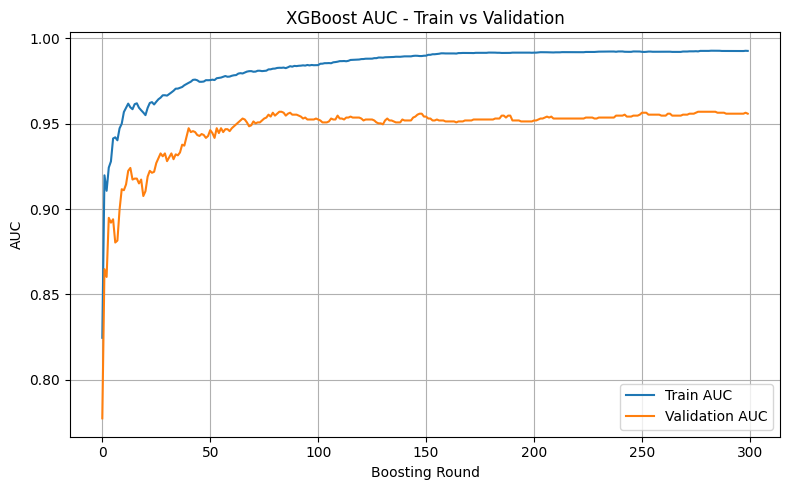

In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split data into train and validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Compute class imbalance ratio
scale_pos_weight = sum(y_train_final == 0) / sum(y_train_final == 1)

# Initialize the model (adjust or tune parameters as needed)
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    min_child_weight=5,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# Train with evaluation set (no early stopping)
xgb.fit(
    X_train_final, y_train_final,
    eval_set=[(X_train_final, y_train_final), (X_val, y_val)],
    verbose=False
)

# Get evaluation history
results = xgb.evals_result()

# Plot training vs. validation AUC
epochs = len(results['validation_0']['auc'])
x_axis = range(epochs)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, results['validation_0']['auc'], label='Train AUC')
plt.plot(x_axis, results['validation_1']['auc'], label='Validation AUC')
plt.xlabel('Boosting Round')
plt.ylabel('AUC')
plt.title('XGBoost AUC - Train vs Validation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Both curve move on the same rate and plateaus at the same time.**

**We can confirm that the model is not overfitting.**

### Use SHAP to Check for Information from the Model

c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


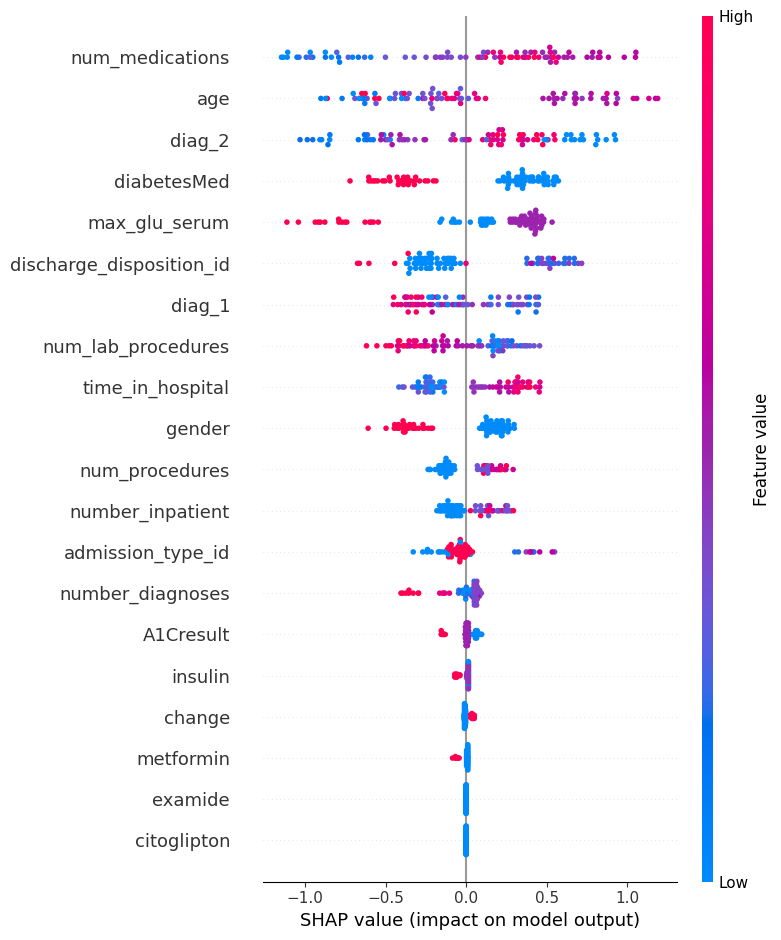

In [27]:
import shap

# Initialize JavaScript visualizations
shap.initjs()

# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values (this can be slow on large datasets)
shap_values = explainer.shap_values(X_val)

# Global summary plot
shap.summary_plot(shap_values, X_val)


The following insights were derived from SHAP analysis of the XGBoost model trained on hospital readmission data

1. Number of Medications

The number of medications a patient is prescribed is one of the most significant predictors of readmission. Patients with fewer medications tend to have lower readmission risk, while a higher medication count may indicate complex or poorly controlled conditions.

2. Age

Age shows a positive relationship with readmission risk. While there are some outliers, the general trend indicates that older patients are more likely to be readmitted, possibly due to increased frailty or comorbidities.

3. Diabetes Medication Usage

Whether or not a patient is prescribed diabetes medication is a strong feature. Interestingly, patients on diabetic medication were less likely to be readmitted, which may reflect ongoing disease management and adherence to treatment.

4. Number of Lab Procedures

Patients who underwent more lab procedures were less likely to be readmitted. This could suggest that more thorough diagnostic workups during the initial visit contribute to better outcomes or earlier interventions.

5. Gender Differences

Gender showed a measurable impact: in this model, males were less likely to be readmitted than females. While the reason is unclear from the data alone, it highlights the importance of considering demographic factors in healthcare modeling.